# Limpieza y tranformación de datos del mercado inmobiliario en la Ciudad de Buenos Aires

Este segundo proyecto, que es una continuación del proyecto Exploración de datos, se continua trabajando con el dataset 
de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo es seguir con la limpieza de datos, remover valores faltantes y outliers. Ademas, se agregan nuevos atributos basados en los datos.

## Dataset: Propiedades en venta, Buenos Aires
El dataset que se utiliza en este proyecto corresponde a una muestra de propiedades en venta, publicado en la página de Properati (www.properati.com.ar), en el cual, cada fila es una propiedad en venta. 
<br><br>Este dataset ha sido filtrado en el proyecto anterior, para trabajar solo con casas (house), departamentos (apartment) y PH (PH). También están hechas las correcciones de coordenadas y superficies incorrectas. 

## Atributos
Los atributos que contiene esta muestra son:

* **id**: id de la propiedad
* **created_on**: fecha de ingreso al sitio de la propiedad
* **operation**: alquiler (rent) o venta (sell)
* **property_type**: tipo de propiedad (casa, departamento, ph, etcétera)
* **place_with_parent_names**: ubicación de la propiedad según el publicador
* **lat-lon**: coordenadas concatenadas
* **lat**: latitud
* **lon**: longitud
* **price**: precio en la moneda especificada en currency
* **currency**: divisa en la que está expresada la publicación
* **price_aprox_usd**: precio aproximado en dólares estadounidenses
* **surface_total_in_m2**: superficie total (en metros cuadrados)
* **surface_covered_in_m2**: superficie cubierta (en metros cuadrados)
* **price_usd_per_m2**: precio por metro cuadrado en dólares (precio dólares / superficie)
* **floor**: número de piso (si corresponde)
* **rooms**: cantidad de ambientes
* **expenses**: expensas (si corresponde)
* **barrio**: barrio según cartografía oficial
* **properati_url**: url de la publicación en Properati

Para proceder con la exploración de los datos, incluyendo limpieza y visualización del dataset, es necesario  importar bibliotecas como numpy, pandas, matplotlib.pylab y seaborn. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
 
sns.set_style("whitegrid")
sns.set_context("paper")

plt.rcParams['figure.figsize'] = (12,5)

In [2]:
#path_dataset = 'dataset/datos_properati_limpios.csv'
#df = pd.read_csv(path_dataset, parse_dates=['created_on'])
df = pd.read_csv("datos_properati_limpios.csv", parse_dates=['created_on'])

In [3]:
df.columns

Index(['created_on', 'property_type', 'place_name', 'place_with_parent_names',
       'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms',
       'expenses', 'properati_url', 'barrio'],
      dtype='object')

In [4]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 13756 observaciones


### Outliers

En primer lugar se analizan los valores extremos que puede haber en los precios y en las superficies, Esta medida es útil para luego imputar usando medidas de tendencia central, como el promedio. Como estas medidas pueden ser sensibles a outliers, la imputación de valores faltantes puede verse afectada.

Puede surgir duda sobre la conveniencia de imputar faltantes y luego remover outliers, o realizarlo en orden contrario. Al imputar, se modifica la distribución de los datos, es por eso que las cotas que se utilicen para definir los outliers se verán afectadas por este cambio y modificarán los resultados finales. Por ello es conveniente comenzar quitando outliers.

En este punto se trabaja con "price_usd_per_m2". Precios altos pueden corresponder a grandes superficies, por lo que conviene analizar juntos ambos atributos. A continuación, se ve la distribución de los valores y un boxplot para comenzar a identificar los outliers.

**1.** Se utiliza **Seaborn** para hacer un "distplot" del precio por metro cuadrado. Adicionalmente, se hace un "drop" de los valores `NaN` de esta columna antes de graficar.

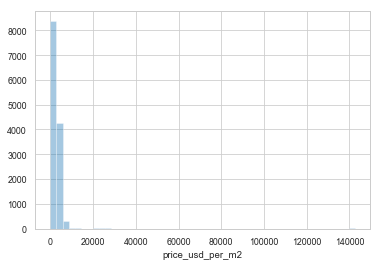

In [5]:
df.dropna(subset=['price_usd_per_m2'])
x=df['price_usd_per_m2'].dropna()
sns.distplot(x,kde=False)         
plt.show()

**2.** Se muestra un "boxplot" de la columna 'price_usd_per_m2'.

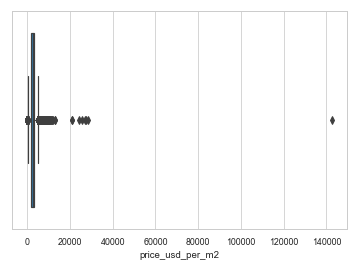

In [6]:
x=df['price_usd_per_m2'].dropna()
sns.boxplot(x)         
plt.show()

Analizando los gráficos anteriores se puede concluir que existen valores extremos u outliers en esta columna, los cuales podrían afectar la estimación de ciertos parámetros estadísticos como la media. Para confirmar de nuevo la presencia de outliers se observarán los percentiles mas adelante.

**3. Parámetros Estadísticos** sobre la columna 'price_usd_per_m2':

In [7]:
df.price_usd_per_m2.describe()

count     12973.000000
mean       2695.065767
std        1773.086831
min           0.958333
25%        1959.183673
50%        2510.204082
75%        3125.000000
max      142450.141026
Name: price_usd_per_m2, dtype: float64

Como existen valores extremos en ambas puntas de la distribución, se aplica la técnica del rango intercuartílico para limpiarlos. Se obtiene el rango calculando la diferencia entre el tercer y el primer cuartil. Luego en base a esto se calculan los valores mínimos y máximos para definir cuáles observaciones serán descartadas.

**4. Rango intercuartílico**

In [8]:
df.price_usd_per_m2.quantile([0.25,0.75])

0.25    1959.183673
0.75    3125.000000
Name: price_usd_per_m2, dtype: float64

In [9]:
q1 = df.price_usd_per_m2.quantile(0.25)
q3 = df.price_usd_per_m2.quantile(0.75)
iqr = q3-q1
minimo  = q1-1.5*iqr
maximo = q3+1.5*iqr
df.price_usd_per_m2[(df.price_usd_per_m2 > minimo) & (df.price_usd_per_m2 < maximo)]
df_filtered = df[(df.price_usd_per_m2 > minimo) & (df.price_usd_per_m2 < maximo)]
df_filtered

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,barrio
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.00,130.0,120.0,2615.384615,NaN,4.0,8000.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.00,52.0,48.0,4269.230769,NaN,1.0,NaN,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.00,70.0,70.0,2571.428571,NaN,NaN,3000.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.00,532.0,334.0,2255.639098,NaN,6.0,NaN,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO
5,2017-08-30,house,Palermo,|Argentina|Capital Federal|Palermo|,-34.579354,-58.436449,1200000.00,532.0,334.0,2255.639098,NaN,6.0,NaN,https://www.properati.com.ar/1e1vf_venta_casa_...,PALERMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13751,2017-12-17,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668970,-58.443897,49000.00,75.0,75.0,653.333333,NaN,4.0,NaN,https://www.properati.com.ar/1j22x_venta_depar...,VILLA SOLDATI
13752,2018-01-08,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668741,-58.443146,60000.00,55.0,55.0,1090.909091,NaN,3.0,NaN,https://www.properati.com.ar/1jcpm_venta_depar...,VILLA SOLDATI
13753,2018-01-23,house,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.664170,-58.443317,99000.00,115.0,82.0,860.869565,NaN,3.0,NaN,https://www.properati.com.ar/1k1hs_venta_casa_...,VILLA SOLDATI
13754,2018-01-27,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.665005,-58.443041,50433.01,45.0,45.0,1120.733556,NaN,3.0,NaN,https://www.properati.com.ar/1k5v0_venta_depar...,VILLA SOLDATI


**5.** De nuevo se visualizan, a partir de un "distplot" y un "boxplot" los precios sin los outliers y donde se ven calras diferencias respecto los gráficos anteriores.

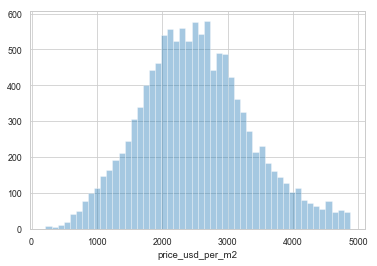

In [10]:
x=df_filtered.price_usd_per_m2
sns.distplot(x,kde=False)         
plt.show()

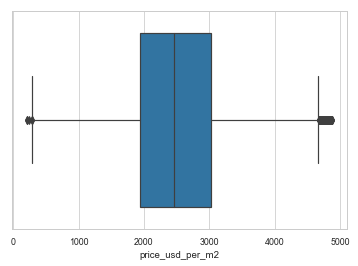

In [11]:
x=df_filtered.price_usd_per_m2
sns.boxplot(x)         
plt.show()

**6.** Se describen nuevamente los parámetros estadísticos de la columna, donde también se observan variaciones.

In [12]:
df_filtered['price_usd_per_m2'].describe()

count    12288.000000
mean      2505.089766
std        834.949633
min        213.068182
25%       1933.333333
50%       2466.666667
75%       3027.864583
max       4871.794872
Name: price_usd_per_m2, dtype: float64

Se continúa el análisis con el Dataframe filtrado:

In [13]:
df = df_filtered

### Valores Faltantes
A diferencia del proyecto anterior, en este se intenta imputar los valores faltantes para los atributos considerados importantes para el mercado inmobiliario. 

Estos atributos son los que informan: superficie (total o cubierta), cantidad de ambientes, precio y precio por metro cuadrado. 

En primer lugar se verá cuántos valores faltantes tiene cada atributo. Como esta información es muy importante, conviene estudiarlo en forma de porcentaje en relación a la cantidad de observaciones, si el porcentaje de valores faltantes en un atributo es elevado, puede ser mejor no considerarlo en el análisis.

**7.** El porcentaje de valores faltantes para cada columna es:

In [14]:
col_null = df.isnull().sum()
print (col_null)
df.isnull().mean() * 100

created_on                     0
property_type                  0
place_name                     0
place_with_parent_names        0
lat                            0
                           ...  
floor                      10455
rooms                       2160
expenses                    9090
properati_url                  0
barrio                         0
Length: 15, dtype: int64


created_on                  0.000000
property_type               0.000000
place_name                  0.000000
place_with_parent_names     0.000000
lat                         0.000000
                             ...    
floor                      85.083008
rooms                      17.578125
expenses                   73.974609
properati_url               0.000000
barrio                      0.000000
Length: 15, dtype: float64

En estos resultados se ve que los atributos 'floor' y 'expenses' tienen un elevado porcentaje de faltantes. Dado el alto porcentaje de faltantes, una opción sería descartar estas columnas en el análisis. Pero si se eliminan las instancias (filas) asociadas a estos, se perdería el 84.79% de los datos, reduciendo demasiado el conjunto de datos.

Otra opción como ejemplo puede ser considerar categorías como faltantes o no faltantes o en todo caso analizar si hay algún patrón para poder evitar quitarlos. Pero en este caso y a fin de avanzar con el proyecto, se prescinde de estos atributos.

In [15]:
df = df.drop(['floor', 'expenses'], axis = 1)

Por otro lado se analizan estrategias para atribuir los valores faltantes para las columnas 'rooms', 'surface_total_in_m2' y 'surface_covered_in_m2'. Algunas opciones pueden reemplazar los faltantes por algún medida de tendencia central, como la media o la mediana, en este caso se utiliza la media en las columnas 'surface_total_in_m2' y 'surface_covered_in_m2' y la mediana para la columna 'rooms'.

Como herramienta bastante usual de imputación, se utiliza Scikit-learn, la cual provee la clase Imputer que permite realizar esta acción.

**8. Imputar los valores faltantes** de las columnas 'surface_total_in_m2' y 'surface_covered_in_m2' utilizando la **media**.

In [16]:
print(df[['surface_total_in_m2', 'surface_covered_in_m2']].isna().sum())

surface_total_in_m2        0
surface_covered_in_m2    474
dtype: int64


In [17]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='mean')
si = si.fit(df[['surface_total_in_m2', 'surface_covered_in_m2']])

df[['surface_total_in_m2', 'surface_covered_in_m2']] = si.transform(df[['surface_total_in_m2', 'surface_covered_in_m2']])

In [18]:
print(df[['surface_total_in_m2', 'surface_covered_in_m2']].isna().sum())

surface_total_in_m2      0
surface_covered_in_m2    0
dtype: int64


**Nota:** Una de las limitaciones que presenta este tipo de imputación es que provoca estimaciones sesgadas de la varianza. Esto impacta en los errores estandar y por ende, en los tests estadísticos.

Este tipo de técnicas es útil cuando los valores son completamente al azar.

**9. Imputar las observaciones faltantes** de la columna 'rooms' usando la **mediana**.

In [19]:
print(df[['rooms']].isna().sum())

rooms    2160
dtype: int64


In [20]:
# Imputar con la mediana en esta celda
si = SimpleImputer(strategy='median')
#si = si.fit(df[['surface_total_in_m2', 'surface_covered_in_m2']])
df[['rooms']] = si.fit_transform(df[['rooms']])

In [21]:
print(df[['rooms']].isna().sum())

rooms    0
dtype: int64


### Variables binarias

Continuando con el proyecto, se procede a generar variables binarias para la columna 'property_type'. Como en este caso el atributo es categórico y sus valores estan en formato string (secuencia de caracteres), se utiliza Scikit-learn para convertirlos en valores numéricos. 

**10.** Se utiliza LabelEncoder sobre 'property_type'

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df[['property_type']])

C:\Users\educa\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [23]:
le.transform(df[['property_type']])

C:\Users\educa\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, ..., 2, 1, 1])

**11.** A continuación se visualizan las clases creadas a partir del LabelEncoder:

In [24]:
le.classes_

array(['PH', 'apartment', 'house'], dtype=object)

 **12.** Se utiliza OneHotEncoder sobre las variables categóricas de 'property_type' para crear un dataframe de variables binarias, el cual se llamará "categoricals_df".

In [25]:
categoricals_df = le.transform(df[['property_type']])
categoricals_df

C:\Users\educa\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, ..., 2, 1, 1])

In [26]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse = False)
categoricals_df = categoricals_df.reshape(len(categoricals_df),1)
categoricals_df

array([[1],
       [1],
       [1],
       ...,
       [2],
       [1],
       [1]])

In [27]:
categoricals_df = enc.fit_transform(categoricals_df)
categoricals_df.shape

C:\Users\educa\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(12288, 3)

Se observa la matriz creada:

In [28]:
print(categoricals_df)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [29]:
categoricals_df = pd.DataFrame(categoricals_df)

**13.** Como siguiente paso, se quiere unir el nuevo dataframe "categorical_df" con el dataframe original "df". Para esto, es necesario que tengan el mismo índice, por lo cual se utiliza la herramienta Concat de Pandas que tiene esta función.

In [30]:
categoricals_df = categoricals_df.set_index(df.index)
df = pd.concat([df, categoricals_df], axis=1)
df.head()

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio,0,1,2
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.0,130.0,120.0,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO,0.0,1.0,0.0
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.0,52.0,48.0,4269.230769,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO,0.0,1.0,0.0
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.0,70.0,70.0,2571.428571,3.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO,0.0,1.0,0.0
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.0,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO,0.0,0.0,1.0
5,2017-08-30,house,Palermo,|Argentina|Capital Federal|Palermo|,-34.579354,-58.436449,1200000.0,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1vf_venta_casa_...,PALERMO,0.0,0.0,1.0


### Variables calculadas

__14.__ A continuación se crea una nueva columna 'price_m2', que es el resultado de calcular el precio por metro cuadrado (precio/superficie total). Como dividir por cero generaría un error, se crea una función que contemple esto, en el caso de que la superficie total sea un valor faltante o cero.

**Nota:** Crear una columna nueva y no imputar los faltantes es simplemente una decisión. En el caso de modelos predictivos, este tipo de decisiones puede afectar en términos de performance del modelo.

In [31]:
def custom_division(x, y):
    if y > 0:
        res = x / y
    else:
        res = 0
    return res

df['price_m2'] = df.apply(lambda x: custom_division
                          (x['price_aprox_usd'], x['surface_total_in_m2']), axis = 1)
df.drop(['price_usd_per_m2'], axis=1, inplace=True)


A continuación se verifica que ya no quedan atributos con valores faltantes, creando un dataframe con los porcentajes nulos y después se muestran los que tengan valores nulos. Si el porcentsaje es cero, no se muestra.

In [32]:
df_faltantes = pd.DataFrame(df.isnull().sum() / df.shape[0], columns=['Porcentaje nulos'])
df_faltantes.loc[~(df_faltantes==0).all(axis=1)]
df

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,properati_url,barrio,0,1,2,price_m2
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.00,130.0,120.0,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO,0.0,1.0,0.0,2615.384615
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.00,52.0,48.0,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO,0.0,1.0,0.0,4269.230769
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.00,70.0,70.0,3.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO,0.0,1.0,0.0,2571.428571
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.00,532.0,334.0,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO,0.0,0.0,1.0,2255.639098
5,2017-08-30,house,Palermo,|Argentina|Capital Federal|Palermo|,-34.579354,-58.436449,1200000.00,532.0,334.0,6.0,https://www.properati.com.ar/1e1vf_venta_casa_...,PALERMO,0.0,0.0,1.0,2255.639098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13751,2017-12-17,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668970,-58.443897,49000.00,75.0,75.0,4.0,https://www.properati.com.ar/1j22x_venta_depar...,VILLA SOLDATI,0.0,1.0,0.0,653.333333
13752,2018-01-08,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668741,-58.443146,60000.00,55.0,55.0,3.0,https://www.properati.com.ar/1jcpm_venta_depar...,VILLA SOLDATI,0.0,1.0,0.0,1090.909091
13753,2018-01-23,house,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.664170,-58.443317,99000.00,115.0,82.0,3.0,https://www.properati.com.ar/1k1hs_venta_casa_...,VILLA SOLDATI,0.0,0.0,1.0,860.869565
13754,2018-01-27,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.665005,-58.443041,50433.01,45.0,45.0,3.0,https://www.properati.com.ar/1k5v0_venta_depar...,VILLA SOLDATI,0.0,1.0,0.0,1120.733556


In [33]:
print("El dataset final luego del procesamiento tiene {} observaciones".format(df.shape[0]))

El dataset final luego del procesamiento tiene 12288 observaciones


De esta manera, han sido limpiados los valores extremos y han sido imputados los valores nulos. El costo de estas acciones fue la pérdida de 685 observaciones, es decir sólo el 5% de la cantidad original de filas.